In [13]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    # !git clone https://github.com/pedro15sousa/ABM-emulation.git
    # %cd ABM-emulation
else:
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

if IN_COLAB:
    from google.colab import files, drive
    drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/My Drive/ABM_Simulations_DB/' if IN_COLAB else './'

Not running on Google Colab. Assuming local environment.


In [1]:
%pip install wandb 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!wandb login

In [14]:
# Model Design
# import agentpy as ap 
import numpy as np 
import pandas as pd
import sqlite3
import pickle
import wandb
# from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import ast

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

Device:  cpu


In [3]:
# results = ap.DataDict.load(exp_name='BoidsModel', exp_id=4)
results = pd.read_csv('boids_statistics_results.csv')

In [8]:
db_path = os.path.join(DRIVE_PATH, 'simulation_50k.db')

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Define the SQL query to load results
# This query assumes you want to join the 'jobs' and 'results' tables to fetch
# the parameter index, iteration, and associated result data for all completed jobs
query = '''
SELECT j.param_index, j.iteration, r.result_data
FROM jobs j
JOIN results r ON j.param_index = r.param_index AND j.iteration = r.iteration
WHERE j.status = 'completed'
'''

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# A helper function to deserialize the binary data
def deserialize(data):
    return pickle.loads(data)

# Apply the deserialize function to each row in the result_data column
df['result_data'] = df['result_data'].apply(lambda x: deserialize(x))

results = pd.concat(df['result_data'].tolist(), ignore_index=True)

In [20]:
print(len(results))

54240


In [6]:
def process_data(X, Y, batch_size=64, normalize=True, state=False):
    # Split the data into training+validation set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # spit into training and validation set
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    # Convert pandas dataframes to numpy arrays (if not already in numpy format)
    X_train_np, Y_train_np = X_train.values, Y_train.values
    X_val_np, Y_val_np = X_val.values, Y_val.values
    X_test_np, Y_test_np = X_test.values, Y_test.values

    if normalize:
        # Initialize scalers for X and Y
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        # Fit and transform the training data
        X_train, Y_train= scaler_X.fit_transform(X_train_np), scaler_Y.fit_transform(Y_train_np)
        # Transform the validation and test data
        X_test, Y_test = scaler_X.transform(X_test_np), scaler_Y.transform(Y_test_np)
        X_val, Y_val = scaler_X.transform(X_val_np), scaler_Y.transform(Y_val_np)

    
    # Convert the numpy arrays back to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    Y_val = torch.tensor(Y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    
    # Create TensorDataset objects
    train_dataset = TensorDataset(X_train, Y_train)
    val_dataset = TensorDataset(X_val, Y_val)
    test_dataset = TensorDataset(X_test, Y_test)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [10]:
output_parameters = ['final_alignment', 'cohesion_separation_ratio', 'flock_density']
# output_parameters = ['final_alignment']
knobs = ['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']
# knobs = ['cohesion_strength', 'alignment_strength', 'border_strength']

# Y = results.reporters[output_parameters]
# X =  results.reporters[knobs]
Y = results[output_parameters]
X =  results[knobs]

train_loader, val_loader, test_loader = process_data(X, Y, batch_size=64, normalize=True)

In [12]:
print(X['seperation_strength'].value_counts())

seperation_strength
0.01     7040
0.05     7040
0.10     7040
0.50     7040
1.00     7040
5.00     7040
10.00    6368
15.00    5632
Name: count, dtype: int64


/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/py

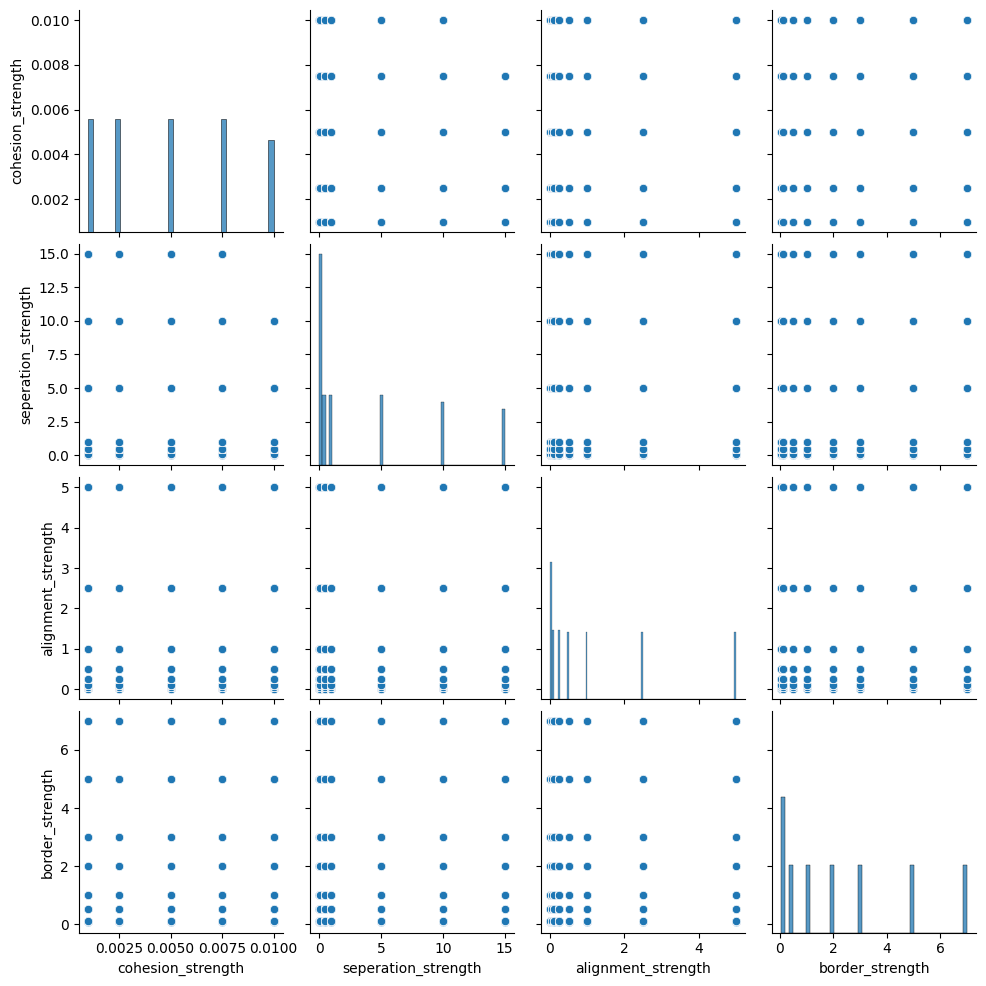

In [13]:
sns.pairplot(X)

In [14]:
correlation_matrix = X.corr()
print(correlation_matrix)

                     cohesion_strength  seperation_strength  \
cohesion_strength             1.000000            -0.111812   
seperation_strength          -0.111812             1.000000   
alignment_strength           -0.013732            -0.011115   
border_strength              -0.000884            -0.000715   

                     alignment_strength  border_strength  
cohesion_strength             -0.013732        -0.000884  
seperation_strength           -0.011115        -0.000715  
alignment_strength             1.000000         0.000229  
border_strength                0.000229         1.000000  


In [23]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, output_size)   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [46]:
class SuperEnhancedNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SuperEnhancedNet, self).__init__()
        # Significantly increase the capacity of the network
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer to 1024 neurons
        self.bn1 = nn.BatchNorm1d(1024)        # Batch normalization layer
        self.fc2 = nn.Linear(1024, 512)        # First hidden layer
        self.bn2 = nn.BatchNorm1d(512)         # Batch normalization layer
        self.fc3 = nn.Linear(512, 512)         # Second hidden layer
        self.dropout1 = nn.Dropout(0.5)        # Dropout layer for regularization
        self.fc4 = nn.Linear(512, 256)         # Third hidden layer
        self.bn3 = nn.BatchNorm1d(256)         # Batch normalization layer
        self.fc5 = nn.Linear(256, 256)         # Fourth hidden layer
        self.dropout2 = nn.Dropout(0.5)        # Another dropout layer
        self.fc6 = nn.Linear(256, 128)         # Fifth hidden layer
        self.bn4 = nn.BatchNorm1d(128)         # Batch normalization layer
        self.fc7 = nn.Linear(128, 64)          # Sixth hidden layer
        self.fc8 = nn.Linear(64, output_size)    # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout1(x)
        x = F.relu(self.fc4(x))
        x = self.bn3(x)
        x = F.relu(self.fc5(x))
        x = self.dropout2(x)
        x = F.relu(self.fc6(x))
        x = self.bn4(x)
        x = F.relu(self.fc7(x))
        x = self.fc8(x)  # No activation function in the output layer
        return x

In [23]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  
        self.fc2 = nn.Linear(1024, 512)         
        self.fc3 = nn.Linear(512, 256)  
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, output_size)   # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)  # No activation function in the output layer
        return x

In [ ]:
class RegressionNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionNet, self).__init__()
        # Define the network layers
        self.layer1 = nn.Linear(input_size, 256)  # Increased size
        self.layer2 = nn.Linear(256, 128)         # New layer
        self.layer3 = nn.Linear(128, 64)          # Adjusted size
        self.layer4 = nn.Linear(64, output_size)  # Additional layer
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)  # No activation for the output layer
        return x

In [11]:
wandb.init(project="boids-emulation-forwards", entity="pemisousa-sousa")

lr = 0.05
epochs = 1000

wandb.config = {
    'learning_rate': lr,
    "epochs": epochs,
    "batch_size": 64,
    "lr_decay": 0.99,  # Decay factor for the learning rate
}

input_size = X.shape[1]
output_size = Y.shape[1]
model = RegressionNet(input_size, output_size)

# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=wandb.config['lr_decay'])  # Setup the scheduler

# Training loop
for epoch in range(epochs):  # Number of epochs
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()   # Zero the gradient buffers
        output = model(inputs)  # Pass the batch through the network
        loss = criterion(output, labels)  # Compute the loss
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()

    avg_training_loss = running_loss / len(train_loader)
    # Print average loss every 100 epochs
    if epoch % 100 == 0 and i == len(train_loader) - 1:
        print(f'Epoch {epoch+1}, Loss: {avg_training_loss}')
    wandb.log({"epoch": epoch+1, "Training Loss": avg_training_loss})
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    # Print average loss every 100 epochs
    if epoch % 100 == 0 and i == len(train_loader) - 1:
        print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss}')
    wandb.log({"epoch": epoch+1, "Validation Loss": avg_val_loss})

    # Step the scheduler
    scheduler.step()

    # Optional: Log current learning rate
    current_lr = scheduler.get_last_lr()[0]
    wandb.log({"epoch": epoch+1, "Learning Rate": current_lr})

wandb.finish()

NameError: name 'Net' is not defined

In [25]:
# Assuming 'model' is your trained model and 'loss_fn' is your loss function
model.eval()  # Set the model to evaluation mode

total_loss = 0.0
total_samples = 0

with torch.no_grad():  # Do not calculate gradients to save memory
    for inputs, labels in test_loader:
        # Calculate the predictions for the current batch
        outputs = model(inputs)

        # Calculate the loss for the current batch
        loss = criterion(outputs, labels)
        
        # Aggregate the loss
        total_loss += loss.item() * inputs.size(0)  # Multiply by batch size to get total loss for this batch
        total_samples += inputs.size(0)

# Calculate average loss over all samples
average_loss = total_loss / total_samples

print(f'Test loss: {average_loss}')

Test loss: 0.17585211618635857


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store predictions and actual values
all_preds = []
all_true = []

with torch.no_grad():  # Ensure no gradients are calculated
    for inputs, labels in test_loader:  # Iterate over batches from the test DataLoader
        # Generate predictions
        outputs = model(inputs)
        
        # Store predictions and true values
        all_preds.extend(outputs.detach().cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays for evaluation
all_preds_np = np.array(all_preds)
all_true_np = np.array(all_true)

# Calculate the metrics
mae = mean_absolute_error(all_true_np, all_preds_np)
mse = mean_squared_error(all_true_np, all_preds_np)
r2 = r2_score(all_true_np, all_preds_np)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')


MAE: 0.17585192620754242, MSE: 0.2604040801525116, R^2: 0.7416203062356906


/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pmms2/ABM-emulation/py_env/lib/python3.11/site-packages/IPython/core/py

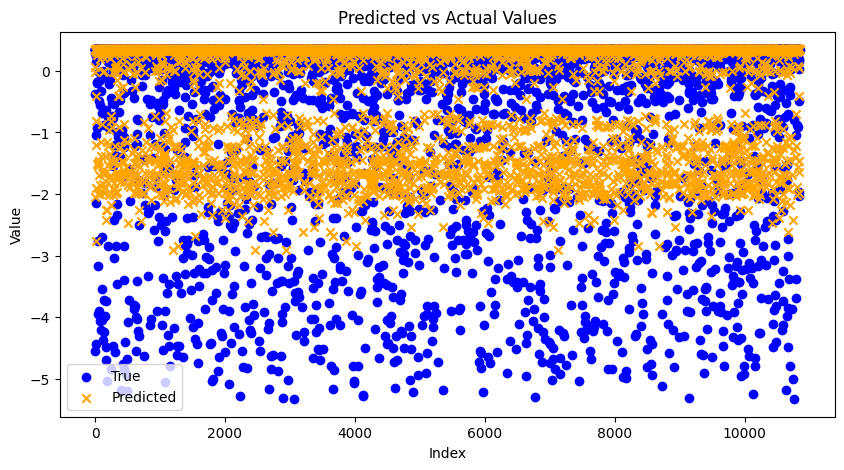

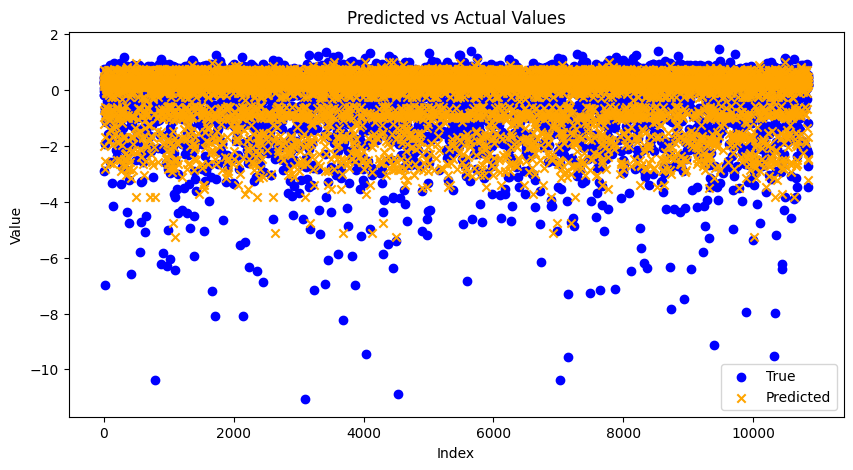

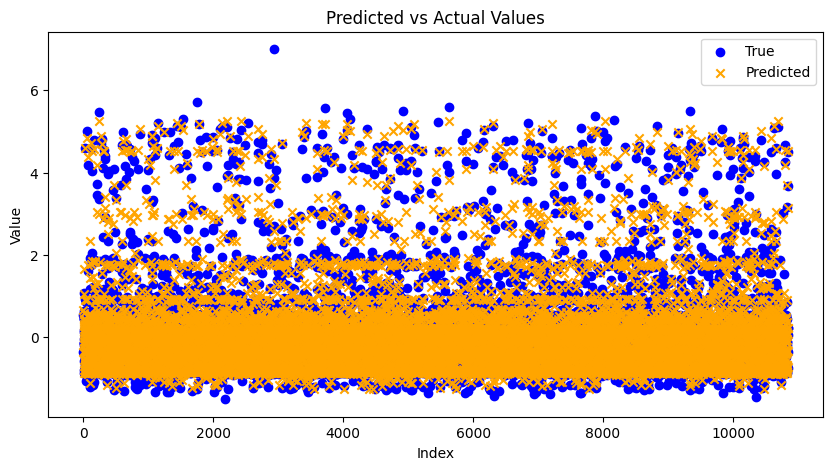

In [27]:
# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(all_true_np.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(all_true_np[:, i])), all_true_np[:, i], color='blue', label='True')
    plt.scatter(range(len(all_preds_np[:, i])), all_preds_np[:, i], color='orange', label='Predicted', marker='x')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

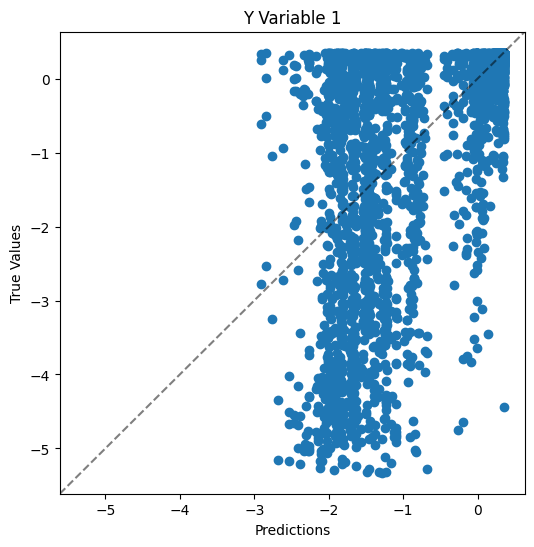

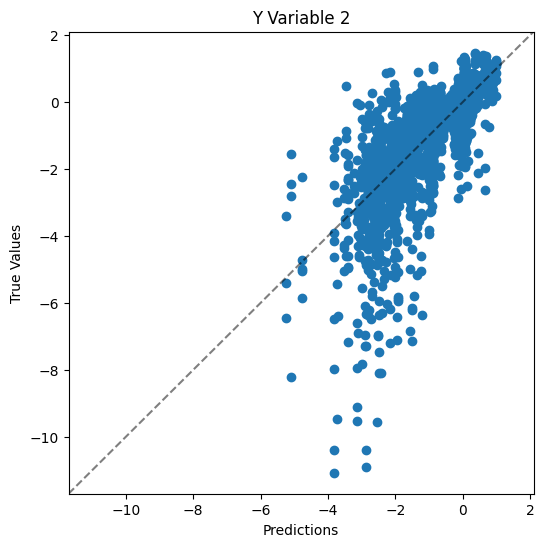

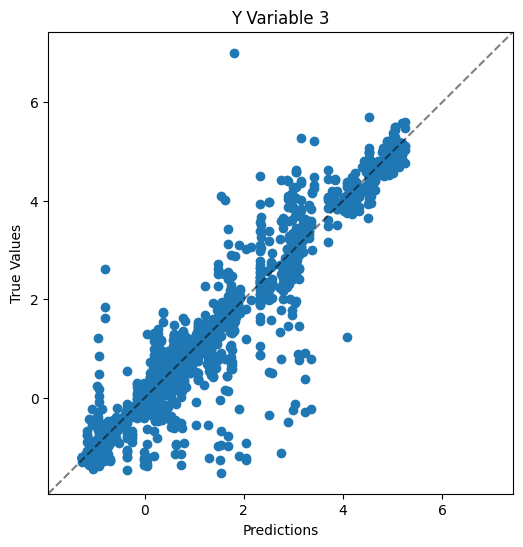

In [28]:
# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(all_true_np.shape[1]):
    plt.figure(figsize=(6, 6))
    plt.scatter(all_preds_np[:, i], all_true_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()